In [107]:
import geopandas as gpd
from matplotlib import pyplot as plt
import cartopy
import pandas as pd
import networkx as nx
import re
import numpy as np

# Initialize and Process Full Graph

In [108]:
#network from data
original=nx.Graph()

# add nodes
nodes = pd.read_csv("nodes_DE2023_methane.csv")
for i in range(0, nodes.shape[0]):
	# id,name,alias,type,x,y,height
	node = nodes.iloc[i]
	original.add_node(node.id, name=node.name, alias=node.alias, type=node.type, x=node.x, y=node.y, height=node.height)

# add edges
edges = pd.read_csv("edges_DE2023_methane.csv")
for i in range(0, edges.shape[0]):
	#id,node0_id,node1_id,name,alias,type,diameter,length,roughness,rin,rout,pimin,pomax
	edge = edges.iloc[i]
	original.add_edge(edge.node0_id, edge.node1_id, id=edge.id, name=edge.name, alias=edge.alias, type=edge.type, length=edge.length, roughness=edge.roughness, rin=edge.rin, rout=edge.rout, pimin=edge.pimin, pomax=edge.pomax)


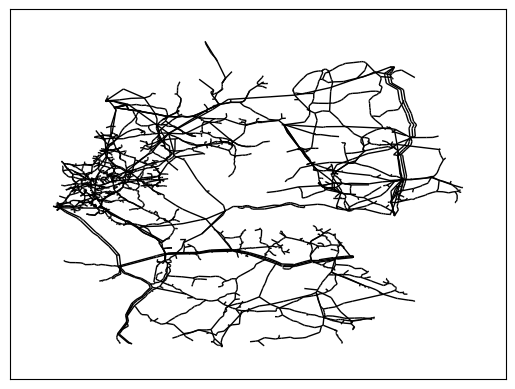

In [109]:
original_pos = {node: (data["x"], data["y"]) for node, data in original.nodes(data=True)}
nx.draw_networkx_edges(original, original_pos)

In [110]:
# translate every entry in nodes["alias"] to its property, save in nodes["type"]
nodes["type"] = nodes["alias"].copy().apply(lambda x: ''.join(re.findall(r'([A-Z]|[a-z])', str(x).split("_")[0]))).to_numpy()
# fill nan values in nodes["type"] with N
nodes["type"] = nodes["type"].apply(lambda x: "N" if str(x) == "nan" else x)

# Initialize NUTS Regions

In [111]:
nuts3 = gpd.read_file("./NUTS3/NUTS_RG_20M_2024_4326.shp").set_index("NUTS_ID")
nuts3 = nuts3[nuts3["LEVL_CODE"] == 3]
nuts3.head(3)

,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,geometry
NUTS_ID,,,,,,,,
AL011,3,AL,Dibër,Dibër,NaN,NaN,NaN,"POLYGON ((20.2208 41.86937, 20.56287 41.84614,..."
AL012,3,AL,Durrës,Durrës,NaN,NaN,NaN,"POLYGON ((19.55733 41.57767, 19.83218 41.56823..."
AL013,3,AL,Kukës,Kukës,NaN,NaN,NaN,"POLYGON ((20.59429 41.87733, 20.56287 41.84614..."


<GeoAxes: >

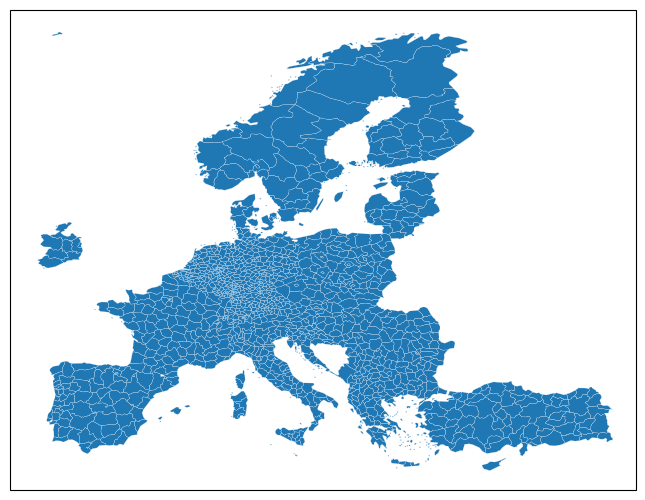

In [112]:
ax = plt.axes(
	[0, 0, 1, 1],
    projection=cartopy.crs.PlateCarree(),
	)

extent = [-13, 47, 33, 73]
ax.set_extent(extent, cartopy.crs.PlateCarree())

nuts3.plot(
	ax=ax,
	edgecolor='white',
	linewidth=0.15,

	)

# Define Scoring-Functions

In [113]:
#Complexity
def complexity(simplified:nx.Graph):
    # calculate node count score
    nodes_score = simplified.number_of_nodes() / original.number_of_nodes()
    
    # calculate edge count score
    edges_score = simplified.number_of_edges() / original.number_of_edges()
    
    # calculate average degree score
    original_avg_degree = sum([x[1] for x in nx.degree(original)]) / len(nx.degree(original))
    simplified_avg_degree = sum([x[1] for x in nx.degree(simplified)]) / len(nx.degree(simplified))
    avg_degree_score = simplified_avg_degree / original_avg_degree

    # average the three complexity scores and return result
    return 1 - ((nodes_score + edges_score + avg_degree_score) / 3)

complexity(original)

0.0

In [114]:
#Structure
def structure():
	return 0

print(structure())

0


In [115]:
#Regionality: Keep many regions connected to the network

def count_regions(df:pd.DataFrame):
	# create dataframe from nodes["id"], nodes["x"], nodes["y"]
	df = gpd.GeoDataFrame(df["id"].copy())
	df = df.set_geometry(gpd.points_from_xy(nodes["x"], nodes["y"]), crs="EPSG:3035").to_crs("EPSG:4326")

	# merge nuts regions file with id-point dataframe
	df = df.sjoin(nuts3, how="left", predicate='within')

	# reduce merged dataframe to unique regions with number of nodes per region
	df = df.value_counts("NUTS_ID")

	# filter for rows, that contain regions with nodes
	df = df[df > 0]

	# count number of lines
	return df.size

def regionality(simplified:pd.DataFrame):
	# calculate score from difference in number of regions
	return count_regions(simplified) / count_regions(nodes)

print(regionality(nodes))

1.0


In [116]:
#Properties: Keep important nodes
def properties(df:pd.DataFrame):
    # calculate properties score from 
    return properties_df(df) / properties_df(nodes)
    
def properties_df(df:pd.DataFrame):
    # count how often each unique element occurs
    count = df["type"].value_counts().reset_index()
    # count node types, apply weights, add weighted count
    score = 0
    for i in range(0, count.shape[1]):
        match count["type"].iloc[i]:
            case "DSO": score += count["count"].iloc[i]
            case "IND": score += count["count"].iloc[i]
            case "TPP": score += count["count"].iloc[i]*0.75
            case "BIO": score += count["count"].iloc[i]*0.25
            case "GPR": score += count["count"].iloc[i]*0.25
            case "GS": score += count["count"].iloc[i]
            case "FUEL": score += count["count"].iloc[i]*0
            case "LNG": score += count["count"].iloc[i]*0.25
            case "IC": score += count["count"].iloc[i]
            case "UGS": score += count["count"].iloc[i]*0.75
            case "N": score += count["count"].iloc[i]*0.5
    return score

print(properties(nodes))

1.0


In [117]:
def score():
    return (3 * complexity(original) + structure() + regionality(nodes) + properties(nodes)) / 6

print(score())

0.3333333333333333


# Run the Algorithms

In [118]:
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity

def run_algo(graph:nx.Graph) -> list[frozenset]:

	results = greedy_modularity_communities(graph)

	# Ergebnisse anzeigen
	print("Gefundene Communities: " + str(len(results)))

	# Modularität berechnen
	mod_value = modularity(original, results)
	print(f"Modularität Q = {mod_value:.4f}")
	return results


In [251]:
def plot_network(graph:nx.Graph, pos:dict[float, float], clusters:list=None, node_size:int=20, title:str="Title"):
    plt.figure(figsize=(8, 10))

    colors = [
        'red', 'blue', 'green', 'orange', 'purple',
        'cyan', 'magenta', 'yellow', 'lime', 'pink',
        'teal', 'gold', 'navy', 'brown', 'olive'
    ]
    if clusters is None:
        clusters = []
        for elem in list(graph.nodes):
            clusters += [[elem]]

    for i, res in enumerate(clusters):
        nx.draw_networkx_nodes(graph, pos, 
                            nodelist=res, 
                            node_size=node_size, 
                            node_color=colors[i % len(colors)]
        )

    nx.draw_networkx_edges(graph, pos, alpha=1)

    plt.title(title)
    plt.show()


In [234]:
results = run_algo(original)

Gefundene Communities: 72
Modularität Q = 0.9615


In [179]:
index = []
nodes = []
for i in range(len(results)):
	nodes += list(results[i])
	index += [i] * len(results[i]) 
x, y = [], []
for elem in nodes:
	x.append(original_pos[elem][0])
	y.append(original_pos[elem][1])
df = pd.DataFrame({"index": index, "nodes": nodes, "x": x, "y": y})
df


,index,nodes,x,y
0,0,67073,4.573755e+06,3.104093e+06
1,0,67074,4.568727e+06,3.103908e+06
2,0,67075,4.579111e+06,3.127612e+06
3,0,67076,4.575329e+06,3.127867e+06
4,0,67081,4.595414e+06,3.133053e+06
...,...,...,...,...
7941,71,67440,4.211685e+06,3.108630e+06
7942,71,67441,4.194994e+06,3.127782e+06
7943,71,67450,4.155614e+06,3.177969e+06
7944,71,67451,4.156292e+06,3.176411e+06


In [206]:
edges_converter = pd.DataFrame(np.array(original.edges), columns=["nodes_left", "nodes_right"])
edges_converter = edges_converter.merge(df.rename(columns={"nodes":"nodes_left", "index":"index_left"}), on="nodes_left", how="left")
edges_converter = edges_converter.merge(df.rename(columns={"nodes":"nodes_right", "index":"index_right"}), on="nodes_right", how="left")
edges_converter = edges_converter[["index_left", "index_right"]].drop_duplicates()
edges_converter = edges_converter[edges_converter["index_left"] != edges_converter["index_right"]]
edges_converter

,index_left,index_right
1,2,12
53,36,11
81,36,32
107,10,11
126,62,35
...,...,...
9022,40,34
9087,34,5
9109,31,9
9170,54,27


In [161]:
agg_df = df.groupby("index").agg({"x":"mean", "y":"mean"})
agg_df.head(10)

,x,y
index,,
0,4.596916e+06,3.139298e+06
1,4.290539e+06,2.817418e+06
2,4.241325e+06,3.243995e+06
3,4.276279e+06,3.292782e+06
4,4.488321e+06,3.126434e+06
5,4.143879e+06,3.163880e+06
6,4.465002e+06,2.984985e+06
7,4.095330e+06,3.094643e+06
8,4.309642e+06,2.969339e+06


In [209]:
simplified = nx.Graph()
simplified.add_nodes_from(list(agg_df.index))
simplified.add_edges_from(edges_converter.to_numpy())

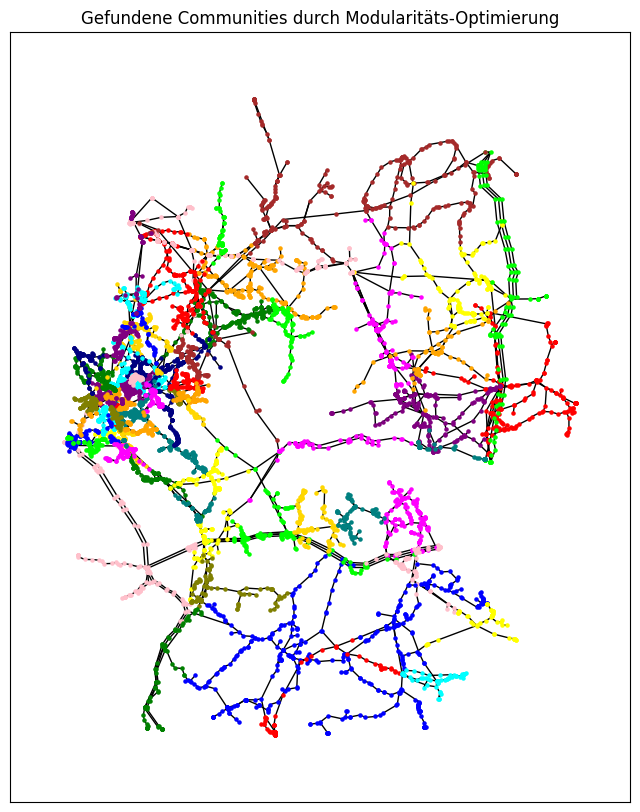

In [256]:
plot_network(graph=original, 
		pos=original_pos, 
		clusters=results, 
		node_size=5, 
		title="Gefundene Communities durch Modularitäts-Optimierung"
)

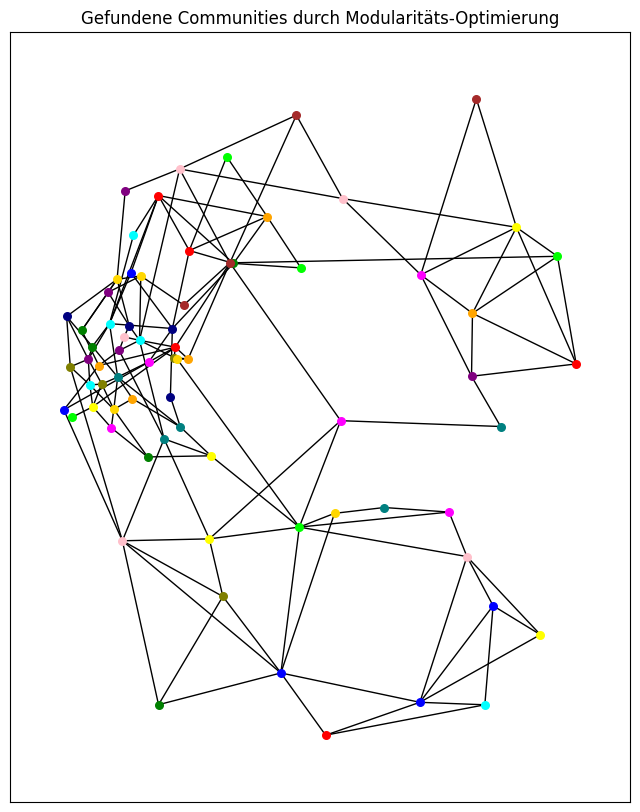

In [258]:
simplified_pos = {i: (agg_df.iloc[i].x, agg_df.iloc[i].y) for i in range(agg_df["x"].size)}
plot_network(graph=simplified, 
		pos=simplified_pos, 
		node_size=30, 
		title="Gefundene Communities durch Modularitäts-Optimierung"
)